<a href="https://colab.research.google.com/github/123ranika/jsfinal/blob/main/sagorsarker_bangla_bert_base_by_farshid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Performing checks for the resources available

In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


### Installing huggingface transformers library

In [ ]:
!pip install transformers

## Importing necessary packages

In [ ]:
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import time
import datetime
from sklearn.metrics import classification_report,confusion_matrix
import random
import time
import torch.nn as nn
from transformers import AutoModel , AutoModelForSequenceClassification, AutoConfig , AutoTokenizer , AdamW ,get_linear_schedule_with_warmup
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
from matplotlib.ticker import MaxNLocator

## Setting some configuration values

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (16,12)

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

## Importing drive into the colaboratory

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

## Loading training data

In [ ]:
import pandas as pd

# Attempt to read the file with ISO-8859-1 encoding
data = pd.read_excel('/content/DataSetxl.xlsx')
data.head()

,text,labels,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,মেধাবী শিক্ষার্থীরাই মা বাবাকে বিদ্যাস্রমে পাটাবে,Cyberbullying,NaN,NaN,NaN,NaN,NaN
1,চিরিয়া খানার এই অদ্ভুত প্রাণী গুলারে রাস্তায়...,Cyberbullying,NaN,NaN,NaN,NaN,NaN
2,শরীর বিক্রি করে পয়সা কামাই করে৷ আবার ভাব কি,Cyberbullying,NaN,NaN,NaN,NaN,NaN
3,এটা কি আমাদের ধর্মজাল,Religious_Hatred,NaN,NaN,NaN,NaN,NaN
4,বেডি আসার আগে দাঁত মাজতে ভুলে গেছে বুঝি।,Cyberbullying,NaN,NaN,NaN,NaN,NaN


In [ ]:
data.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4','Unnamed: 5','Unnamed: 6'],inplace=True)

In [ ]:
data.dropna(inplace=True)

In [ ]:
data.head()

,text,labels
0,মেধাবী শিক্ষার্থীরাই মা বাবাকে বিদ্যাস্রমে পাটাবে,Cyberbullying
1,চিরিয়া খানার এই অদ্ভুত প্রাণী গুলারে রাস্তায়...,Cyberbullying
2,শরীর বিক্রি করে পয়সা কামাই করে৷ আবার ভাব কি,Cyberbullying
3,এটা কি আমাদের ধর্মজাল,Religious_Hatred
4,বেডি আসার আগে দাঁত মাজতে ভুলে গেছে বুঝি।,Cyberbullying


In [ ]:
# Add an ID column starting from 1
data['PID'] = range(1, len(data) + 1)

In [ ]:
data.head()

,text,labels,PID
0,মেধাবী শিক্ষার্থীরাই মা বাবাকে বিদ্যাস্রমে পাটাবে,Cyberbullying,1
1,চিরিয়া খানার এই অদ্ভুত প্রাণী গুলারে রাস্তায়...,Cyberbullying,2
2,শরীর বিক্রি করে পয়সা কামাই করে৷ আবার ভাব কি,Cyberbullying,3
3,এটা কি আমাদের ধর্মজাল,Religious_Hatred,4
4,বেডি আসার আগে দাঁত মাজতে ভুলে গেছে বুঝি।,Cyberbullying,5


In [ ]:
import pandas as pd

# Function to rename a single column
def change_column_name(df, old_name, new_name):
    df = df.rename(columns={old_name: new_name})
    return df

# Assuming df is your DataFrame
data = change_column_name(data, old_name="labels", new_name="labels")
data = change_column_name(data, old_name="text", new_name="text")
data.head() # Display the first few rows of the DataFrame
#text


# Move the ID column to the first position
cols = ['PID'] + [col for col in data.columns if col != 'PID']
data = data[cols]

data.head()

,PID,text,labels
0,1,মেধাবী শিক্ষার্থীরাই মা বাবাকে বিদ্যাস্রমে পাটাবে,Cyberbullying
1,2,চিরিয়া খানার এই অদ্ভুত প্রাণী গুলারে রাস্তায়...,Cyberbullying
2,3,শরীর বিক্রি করে পয়সা কামাই করে৷ আবার ভাব কি,Cyberbullying
3,4,এটা কি আমাদের ধর্মজাল,Religious_Hatred
4,5,বেডি আসার আগে দাঁত মাজতে ভুলে গেছে বুঝি।,Cyberbullying


In [ ]:


# Keep only the specified three columns
# Replace 'column1', 'column2', 'column3' with your actual column names
data = data[['PID', 'text', 'labels']]

# Report the number of sentences
print('Number of training sentences: {:,}\n'.format(data.shape[0]))

# Display 10 random rows from the data
print(data.sample(10))


Number of training sentences: 9,167

       PID                                               text  \
8324  8242  ওই খানকিরে সব ছাএ ভাইয়েরা মিলা ছুদেন তাই নাকি ...   
7014  6933                বেহায়া নারীর ইসলাম নিয়ে মাথাব্যথা   
7529  7448                          তুই একটা শুয়োরের বাচ্চা।   
2624  2625                    পা চাটলে সঙ্গী, না চাটলে জ/ঙ্গী   
1227  1228                                     সেই সুদানির জি   
2859  2860                   নিরাপত্তা চাওয়া বিলাসিতা মাত্র।   
5895  5815  ব্যাপারটা ফানি হলেও বিএনপি ক্ষমতায় আসলে এরকমট...   
7513  7432             ছেলেরা মেয়েদের মতো কষ্ট করতে পারে না।   
2173  2174                    পাগলে চু*** লে এমন করে পোলাপাইন   
7670  7589             তুই ধর্মের নামে ফালতু কথা বলছিস, শালা।   

                     labels  
8324          Cyberbullying  
7014  Gender_Discrimination  
7529          Cyberbullying  
2624              Political  
1227          Cyberbullying  
2859                Sarcasm  
5895              Political  
7513  G

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# # Read the file with ISO-8859-1 encoding
# train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Nazir Sir/spam - spam.csv', encoding='ISO-8859-1')

# First, split the data into training and temp (test + validation)
train_df, temp_df = train_test_split(data, test_size=0.2, random_state=42)

# Then split temp_data into test and validation sets (50% each of temp_data, so 15% of the total for each)
test_df, val_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [ ]:
train_df

,PID,text,labels
2816,2817,র মা কে বিয়ে করতে চাই,Cyberbullying
4837,4764,শুয়োরের বাচ্চা সালা,Cyberbullying
4977,4904,লাবর মেয়েদের ভবিষ্যৎ,Cyberbullying
7131,7050,মানুষ নিজের সন্তানকে নিয়ে এখন চিন্তায় আছে। যে ...,Gender_Discrimination
8295,8213,আসামের রোহিঙ্গা মুসলমানদের তারিয়ে দেওয়া হোক ক...,Racism
...,...,...,...
5815,5735,বাঙালি জাতিকে বিশ্বের সামনে তোরা লজ্জিত করিস ন...,Racism
5265,5192,"যেখানেই বেহায়াপনা, সেখানেই বিবিসির ব্যবসা রমরমা।",Sarcasm
5464,5391,যার মনে হিংসা ক্ষোভ সেই সব ধর্মীয় বিরোধী।,Religious_Hatred
860,861,অতি টিপার ফল,Cyberbullying


In [ ]:
test_df

,PID,text,labels
6860,6779,"বর্ণবাদী মন্তব্য মানুষকে বিভক্ত করে, আর পৃথিবী...",Racism
2245,2246,লাজ লজ্জা হিন কিছু ফোটফটে সুন্দর,Cyberbullying
7133,7052,খুন লুটপাট ডাকাতি অগ্নিসংযোগ শিক্ষক লাঞ্চিত কর...,Gender_Discrimination
4410,4337,এরা হলো ইসলামের বড় শত্রু,Religious_Hatred
7487,7406,ছেলেরা মেয়েদের মতো কোনো গুরুত্বপূর্ণ কাজ করতে...,Gender_Discrimination
...,...,...,...
9209,9127,বেশ্যা পেট থেকে জন্ম নিছিস মাগী তোর মায়েরে চুদী,Gender_Discrimination
2994,2961,ও দিবো পান্তার হোটেল,Sarcasm
1402,1403,শোবে তাই গরুর ঘরে শুয়ে থাকে,Cyberbullying
6604,6523,শেখ হাসিনা ছাড়া এ দেশ কারোর কাছে নিরাপদ নয়,Political


In [ ]:
val_df

,PID,text,labels
5696,5616,আমি চিৎকার করে হাসিতে চাহিয়া করিতে পারিনি চিৎ...,Sarcasm
3453,3382,পোলাপাইন পুরাই ডিস্টিং ডিস্টিং,Sarcasm
8604,8522,শালা মাতারচুদ খানকির পোলা ফলো করার মানুষ পাইলিনা,Cyberbullying
3614,3542,কিসের মুজিব কিসের জিয়া দেশ চলবে কোরআন দিয়া,Religious_Hatred
8977,8895,ওবামার গায়ের রঙ কালো ছিলো,Racism
...,...,...,...
8914,8832,ও বালের পরোয়ানা কোন কামে লাগবে না,Cyberbullying
8518,8436,সালা তোদের কে বল যে ভারতের ভিক নিউ,Racism
1691,1692,হেডা থাকলে বেডার অভাব হয় না!,Cyberbullying
6163,6082,"আতিকা! সাদা মনে একটা কথা জানতে চাই, কি পরিমান ...",Gender_Discrimination


In [ ]:
train_df['labels'].value_counts()

,count
labels,
Cyberbullying,1984
Sarcasm,1857
Political,984
Religious_Hatred,891
Racism,815
Gender_Discrimination,802


In [ ]:

le = LabelEncoder()
train_df['labels'] = le.fit_transform(train_df['labels'])

In [ ]:
train_df['labels'].value_counts()

,count
labels,
0,1984
5,1857
2,984
4,891
3,815
1,802


### Loading `train_sentences` and `train_labels`

In [ ]:
# Get the lists of sentences and their labels.
train_sentences = train_df['text'].values
train_labels = train_df['labels'].values

## Saving Class Names

In [ ]:
#data.dropna(inplace=True)

In [ ]:
data.labels.unique()

array(['Cyberbullying', 'Religious_Hatred', 'Gender_Discrimination',
       'Sarcasm', 'Political', 'Racism'], dtype=object)

In [ ]:
class_names = [
           'Cyberbullying', 'Religious_Hatred', 'Gender_Discrimination',
       'Sarcasm', 'Political', 'Racism'
]

## Loading the validation data

In [ ]:
val_df['labels'] = le.transform(val_df['labels'])

In [ ]:

val_df['labels'].value_counts()

,count
labels,
0,271
5,218
2,134
4,107
1,95
3,92


### Loading `val_sentences` and `val_labels`

In [ ]:
# Get the lists of sentences and their labels.
val_sentences = val_df['text'].values
val_labels = val_df['labels'].values

In [ ]:
val_labels

array([5, 5, 0, 4, 3, 4, 5, 0, 5, 4, 4, 4, 3, 5, 5, 5, 3, 4, 2, 5, 0, 5,
       0, 0, 4, 0, 3, 5, 5, 3, 5, 2, 4, 5, 2, 0, 4, 1, 0, 0, 0, 1, 2, 5,
       0, 3, 5, 0, 3, 2, 4, 2, 0, 5, 1, 0, 5, 4, 0, 0, 5, 0, 4, 0, 4, 2,
       3, 5, 0, 5, 5, 0, 0, 3, 0, 0, 4, 3, 2, 0, 0, 3, 2, 0, 5, 5, 4, 0,
       5, 2, 5, 1, 3, 2, 5, 0, 2, 1, 5, 5, 0, 3, 0, 5, 5, 2, 1, 0, 1, 4,
       0, 4, 0, 0, 5, 3, 1, 0, 5, 2, 0, 5, 0, 2, 2, 4, 5, 0, 0, 5, 0, 0,
       4, 5, 0, 3, 3, 5, 1, 1, 1, 0, 1, 0, 5, 0, 2, 4, 0, 3, 3, 0, 5, 0,
       0, 4, 5, 4, 2, 1, 0, 0, 0, 0, 2, 3, 0, 0, 2, 5, 5, 1, 1, 2, 4, 0,
       3, 2, 0, 5, 2, 5, 0, 1, 5, 1, 5, 5, 0, 4, 0, 1, 3, 4, 0, 0, 4, 0,
       4, 5, 1, 2, 0, 5, 5, 0, 2, 5, 2, 2, 0, 5, 1, 5, 3, 4, 5, 2, 0, 0,
       2, 5, 4, 2, 2, 2, 0, 3, 5, 4, 4, 2, 1, 0, 0, 0, 0, 5, 0, 0, 0, 0,
       0, 0, 3, 5, 3, 0, 5, 5, 5, 4, 0, 5, 0, 2, 0, 1, 0, 1, 0, 2, 0, 0,
       5, 0, 0, 4, 3, 3, 3, 5, 0, 0, 5, 3, 4, 3, 5, 2, 1, 2, 2, 0, 1, 3,
       4, 3, 4, 5, 4, 0, 0, 0, 1, 1, 2, 0, 4, 2, 1,

## Helper Functions

#### 1) Update Interval Function

In [ ]:
def good_update_interval(total_iters, num_desired_updates):
    '''
    This function will try to pick an intelligent progress update interval
    based on the magnitude of the total iterations.

    Parameters:
      `total_iters` - The number of iterations in the for-loop.
      `num_desired_updates` - How many times we want to see an update over the
                              course of the for-loop.
    '''
    # Divide the total iterations by the desired number of updates. Most likely
    # this will be some ugly number.
    exact_interval = total_iters / num_desired_updates

    # The `round` function has the ability to round down a number to, e.g., the
    # nearest thousandth: round(exact_interval, -3)
    #
    # To determine the magnitude to round to, find the magnitude of the total,
    # and then go one magnitude below that.

    # Get the order of magnitude of the total.
    order_of_mag = len(str(total_iters)) - 1

    # Our update interval should be rounded to an order of magnitude smaller.
    round_mag = order_of_mag - 1

    # Round down and cast to an int.
    update_interval = int(round(exact_interval, -round_mag))

    # Don't allow the interval to be zero!
    if update_interval == 0:
        update_interval = 1

    return update_interval

#### 2) Format time function

In [ ]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


#### 3) Make Smart Batches function

In [ ]:
def make_smart_batches(text_samples, labels, batch_size,tokenizer,max_input_length):
    '''
    This function combines all of the required steps to prepare batches.
    '''

    print('Creating Smart Batches from {:,} examples with batch size {:,}...\n'.format(len(text_samples), batch_size))

    # =========================
    #   Tokenize & Truncate
    # =========================

    full_input_ids = []

    # Tokenize all training examples
    print('Tokenizing {:,} samples...'.format(len(labels)))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(labels), num_desired_updates=10)

    # For each training example...
    for text in text_samples:

        # Report progress.
        if ((len(full_input_ids) % update_interval) == 0):
            print('  Tokenized {:,} samples.'.format(len(full_input_ids)))

        # Tokenize the sample.
        input_ids = tokenizer.encode(text=text,              # Text to encode.
                                    add_special_tokens=True, # Do add specials.
                                    max_length=max_input_length,
                                    truncation=True,         # Do Truncate!
                                    padding=False)           # DO NOT pad.

        # Add the tokenized result to our list.
        full_input_ids.append(input_ids)

    print('DONE.')
    print('{:>10,} samples\n'.format(len(full_input_ids)))

    # =========================
    #      Select Batches
    # =========================

    # Sort the two lists together by the length of the input sequence.
    samples = sorted(zip(full_input_ids, labels), key=lambda x: len(x[0]))

    print('{:>10,} samples after sorting\n'.format(len(samples)))

    import random

    # List of batches that we'll construct.
    batch_ordered_sentences = []
    batch_ordered_labels = []

    print('Creating batches of size {:}...'.format(batch_size))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(samples), num_desired_updates=10)

    # Loop over all of the input samples...
    while len(samples) > 0:

        # Report progress.
        if ((len(batch_ordered_sentences) % update_interval) == 0 \
            and not len(batch_ordered_sentences) == 0):
            print('  Selected {:,} batches.'.format(len(batch_ordered_sentences)))

        # `to_take` is our actual batch size. It will be `batch_size` until
        # we get to the last batch, which may be smaller.
        to_take = min(batch_size, len(samples))

        # Pick a random index in the list of remaining samples to start
        # our batch at.
        select = random.randint(0, len(samples) - to_take)

        # Select a contiguous batch of samples starting at `select`.
        #print("Selecting batch from {:} to {:}".format(select, select+to_take))
        batch = samples[select:(select + to_take)]

        #print("Batch length:", len(batch))

        # Each sample is a tuple--split them apart to create a separate list of
        # sequences and a list of labels for this batch.
        batch_ordered_sentences.append([s[0] for s in batch])
        batch_ordered_labels.append([s[1] for s in batch])

        # Remove these samples from the list.
        del samples[select:select + to_take]

    print('\n  DONE - Selected {:,} batches.\n'.format(len(batch_ordered_sentences)))

    # =========================
    #        Add Padding
    # =========================

    print('Padding out sequences within each batch...')

    py_inputs = []
    py_attn_masks = []
    py_labels = []

    # For each batch...
    for (batch_inputs, batch_labels) in zip(batch_ordered_sentences, batch_ordered_labels):

        # New version of the batch, this time with padded sequences and now with
        # attention masks defined.
        batch_padded_inputs = []
        batch_attn_masks = []

        # First, find the longest sample in the batch.
        # Note that the sequences do currently include the special tokens!
        max_size = max([len(sen) for sen in batch_inputs])

        # For each input in this batch...
        for sen in batch_inputs:

            # How many pad tokens do we need to add?
            num_pads = max_size - len(sen)

            # Add `num_pads` padding tokens to the end of the sequence.
            padded_input = sen + [tokenizer.pad_token_id]*num_pads

            # Define the attention mask--it's just a `1` for every real token
            # and a `0` for every padding token.
            attn_mask = [1] * len(sen) + [0] * num_pads

            # Add the padded results to the batch.
            batch_padded_inputs.append(padded_input)
            batch_attn_masks.append(attn_mask)

        # Our batch has been padded, so we need to save this updated batch.
        # We also need the inputs to be PyTorch tensors, so we'll do that here.
        # Todo - Michael's code specified "dtype=torch.long"
        py_inputs.append(torch.tensor(batch_padded_inputs))
        py_attn_masks.append(torch.tensor(batch_attn_masks))
        py_labels.append(torch.tensor(batch_labels))

    print('  DONE.')

    # Return the smart-batched dataset!
    return (py_inputs, py_attn_masks, py_labels)


In [ ]:
def make_smart_batches_on_test(text_samples, text_ids, batch_size,tokenizer,max_input_length):
    '''
    This function combines all of the required steps to prepare batches.
    '''

    print('Creating Smart Batches from {:,} examples with batch size {:,}...\n'.format(len(text_samples), batch_size))

    # =========================
    #   Tokenize & Truncate
    # =========================

    full_input_ids = []

    # Tokenize all training examples
    print('Tokenizing {:,} samples...'.format(len(text_samples)))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(text_samples), num_desired_updates=10)

    # For each training example...
    for text in text_samples:

        # Report progress.
        if ((len(full_input_ids) % update_interval) == 0):
            print('  Tokenized {:,} samples.'.format(len(full_input_ids)))

        # Tokenize the sample.
        input_ids = tokenizer.encode(text=text,              # Text to encode.
                                    add_special_tokens=True, # Do add specials.
                                    max_length=max_input_length,
                                    truncation=True,         # Do Truncate!
                                    padding=False)           # DO NOT pad.

        # Add the tokenized result to our list.
        full_input_ids.append(input_ids)

    print('DONE.')
    print('{:>10,} samples\n'.format(len(full_input_ids)))

    # =========================
    #      Select Batches
    # =========================

    # Sort the two lists together by the length of the input sequence.
    samples = sorted(zip(full_input_ids, text_ids), key=lambda x: len(x[0]))

    print('{:>10,} samples after sorting\n'.format(len(samples)))

    import random

    # List of batches that we'll construct.
    batch_ordered_sentences = []
    batch_ordered_ids = []

    print('Creating batches of size {:}...'.format(batch_size))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(samples), num_desired_updates=10)

    # Loop over all of the input samples...
    while len(samples) > 0:

        # Report progress.
        if ((len(batch_ordered_sentences) % update_interval) == 0 \
            and not len(batch_ordered_sentences) == 0):
            print('  Selected {:,} batches.'.format(len(batch_ordered_sentences)))

        # `to_take` is our actual batch size. It will be `batch_size` until
        # we get to the last batch, which may be smaller.
        to_take = min(batch_size, len(samples))

        # Pick a random index in the list of remaining samples to start
        # our batch at.
        select = random.randint(0, len(samples) - to_take)

        # Select a contiguous batch of samples starting at `select`.
        #print("Selecting batch from {:} to {:}".format(select, select+to_take))
        batch = samples[select:(select + to_take)]

        #print("Batch length:", len(batch))

        # Each sample is a tuple--split them apart to create a separate list of
        # sequences and a list of labels for this batch.
        batch_ordered_sentences.append([s[0] for s in batch])
        batch_ordered_ids.append([s[1] for s in batch])

        # Remove these samples from the list.
        del samples[select:select + to_take]

    print('\n  DONE - Selected {:,} batches.\n'.format(len(batch_ordered_sentences)))

    # =========================
    #        Add Padding
    # =========================

    print('Padding out sequences within each batch...')

    py_inputs = []
    py_attn_masks = []
    py_ids = []

    # For each batch...
    for (batch_inputs, batch_ids) in zip(batch_ordered_sentences, batch_ordered_ids):

        # New version of the batch, this time with padded sequences and now with
        # attention masks defined.
        batch_padded_inputs = []
        batch_attn_masks = []

        # First, find the longest sample in the batch.
        # Note that the sequences do currently include the special tokens!
        max_size = max([len(sen) for sen in batch_inputs])

        # For each input in this batch...
        for sen in batch_inputs:

            # How many pad tokens do we need to add?
            num_pads = max_size - len(sen)

            # Add `num_pads` padding tokens to the end of the sequence.
            padded_input = sen + [tokenizer.pad_token_id]*num_pads

            # Define the attention mask--it's just a `1` for every real token
            # and a `0` for every padding token.
            attn_mask = [1] * len(sen) + [0] * num_pads

            # Add the padded results to the batch.
            batch_padded_inputs.append(padded_input)
            batch_attn_masks.append(attn_mask)

        # Our batch has been padded, so we need to save this updated batch.
        # We also need the inputs to be PyTorch tensors, so we'll do that here.
        # Todo - Michael's code specified "dtype=torch.long"
        py_inputs.append(torch.tensor(batch_padded_inputs))
        py_attn_masks.append(torch.tensor(batch_attn_masks))
        py_ids.append(torch.tensor(batch_ids))

    print('  DONE.')

    # Return the smart-batched dataset!
    return (py_inputs, py_attn_masks, py_ids)


#### 4) Function for calculating accuracy per class

In [ ]:
def accuracy_per_class(preds, labels , label_dict):

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict[label]}')
        print(f'Accuracy: {round(100*len(y_preds[y_preds==label])/len(y_true) , 2)}\n')

### 5) Function for plotting training history

In [ ]:
def plot_training_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

  ax1.plot(history['train_loss'], label='train loss')
  ax1.plot(history['val_loss'], label='validation loss')

  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax1.set_ylim([-0.05, 1.05])
  ax1.legend()
  ax1.set_ylabel('Loss')
  ax1.set_xlabel('Epoch')

  ax2.plot(history['train_acc'], label='train accuracy')
  ax2.plot(history['val_acc'], label='validation accuracy')

  ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax2.set_ylim([-0.05, 1.05])
  ax2.legend()

  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')

  fig.suptitle('Training history')

### 6) Function to check accuracy

In [ ]:
def check_accuracy(predictions,true_labels):
  # Combine the results across the batches.
  predictions = np.concatenate(predictions, axis=0)
  true_labels = np.concatenate(true_labels, axis=0)

  # Choose the label with the highest score as our prediction.
  preds = np.argmax(predictions, axis=1).flatten()

  # Calculate simple flat accuracy -- number correct over total number.
  accuracy = (preds == true_labels).mean()

  return accuracy

### 7) Function to evaluate model

In [ ]:
def eval_model(model,py_inputs, py_attn_masks, py_labels):
# Prediction on test set
  t0 = time.time()

  print('Doing validation on {:,} sentences...'.format(len(py_labels)))

  # Put model in evaluation mode
  model.eval()

  # Tracking variables
  predictions , true_labels = [], []

  # Choose an interval on which to print progress updates.
  update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

  # Measure elapsed time.
  t0 = time.time()
  total_val_loss = 0

  # Put model in evaluation mode
  model.eval()

  # For each batch of training data...
  for step in range(0, len(py_inputs)):

      # Progress update every 100 batches.
      if step % update_interval == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          elapsed = format_time(time.time() - t0)

          # Calculate the time remaining based on our progress.
          steps_per_sec = (time.time() - t0) / step
          remaining_sec = steps_per_sec * (len(py_inputs) - step)
          remaining = format_time(remaining_sec)

          # Report progress.
          print('  Batch {:>7,}  of  {:>7,}.    Elapsed: {:}.  Remaining: {:}'.format(step, len(py_inputs), elapsed, remaining))

      # Copy the batch to the GPU.
      b_input_ids = py_inputs[step].to(device)
      b_input_mask = py_attn_masks[step].to(device)
      b_labels = py_labels[step].to(device)

      # Telling the model not to compute or store gradients, saving memory and
      # speeding up prediction
      with torch.no_grad():
        output = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)


      logits = output.logits
      loss = output.loss
      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()

      # Store predictions and true labels
      predictions.append(logits)
      true_labels.append(label_ids)

      total_val_loss += loss.item()

  val_accuracy = check_accuracy(predictions,true_labels)

  validation_time = format_time(time.time() - t0)

  # Calculate the average loss over all of the batches.
  avg_val_loss = total_val_loss / len(py_inputs)


  # print('Accuracy: {:.3f}'.format(val_accuracy))
  return (avg_val_loss,val_accuracy,validation_time)


### 8) Function for making predictions on our test dataset

In [ ]:
def get_predictions(py_inputs, py_attn_masks, py_labels):

  print('Predicting labels for {:,} test batches...'.format(len(py_labels)))

  # Put model in evaluation mode
  model.eval()

  # Tracking variables
  predictions , true_labels = [], []

  # Choose an interval on which to print progress updates.
  update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

  # Measure elapsed time.
  t0 = time.time()

  # Put model in evaluation mode
  model.eval()

  # For each batch of training data...
  for step in range(0, len(py_inputs)):

      # Progress update every 100 batches.
      if step % update_interval == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          elapsed = format_time(time.time() - t0)

          # Calculate the time remaining based on our progress.
          steps_per_sec = (time.time() - t0) / step
          remaining_sec = steps_per_sec * (len(py_inputs) - step)
          remaining = format_time(remaining_sec)

          # Report progress.
          print('  Batch {:>7,}  of  {:>7,}.    Elapsed: {:}.  Remaining: {:}'.format(step, len(py_inputs), elapsed, remaining))

      # Copy the batch to the GPU.
      b_input_ids = py_inputs[step].to(device)
      b_input_mask = py_attn_masks[step].to(device)
      b_labels = py_labels[step].to(device)

      # Telling the model not to compute or store gradients, saving memory and
      # speeding up prediction
      with torch.no_grad():
          # Forward pass, calculate logit predictions
          outputs = model(b_input_ids, b_input_mask)

      logits = outputs.logits

      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()

      # Store predictions and true labels
      predictions.append(logits)
      true_labels.append(label_ids)
      # Combine the results across the batches.
  predictions = np.concatenate(predictions, axis=0)
  true_labels = np.concatenate(true_labels, axis=0)

      # Choose the label with the highest score as our prediction.
  preds = np.argmax(predictions, axis=1).flatten()

  return (preds,true_labels)

### 9) Function for making predictions on test dataset(without labels)

In [ ]:
def get_predictions_test(py_inputs, py_attn_masks,py_ids):

  print('Predicting labels for {:,} test batches...'.format(len(py_inputs)))

  # Put model in evaluation mode
  model.eval()

  # Tracking variables
  predictions , true_labels ,ids = [], [] , []

  # Choose an interval on which to print progress updates.
  update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

  # Measure elapsed time.
  t0 = time.time()

  # Put model in evaluation mode
  model.eval()

  # For each batch of training data...
  for step in range(0, len(py_inputs)):

      # Progress update every 100 batches.
      if step % update_interval == 0 and not step == 0:
          # Calculate elapsed time in minutes.
          elapsed = format_time(time.time() - t0)

          # Calculate the time remaining based on our progress.
          steps_per_sec = (time.time() - t0) / step
          remaining_sec = steps_per_sec * (len(py_inputs) - step)
          remaining = format_time(remaining_sec)

          # Report progress.
          print('  Batch {:>7,}  of  {:>7,}.    Elapsed: {:}.  Remaining: {:}'.format(step, len(py_inputs), elapsed, remaining))

      # Copy the batch to the GPU.
      b_input_ids = py_inputs[step].to(device)
      b_input_mask = py_attn_masks[step].to(device)
      b_ids = py_ids[step].to(device)

      # Telling the model not to compute or store gradients, saving memory and
      # speeding up prediction
      with torch.no_grad():
          # Forward pass, calculate logit predictions
          outputs = model(b_input_ids, b_input_mask)

      logits = outputs.logits

      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      b_ids = b_ids.detach().cpu().numpy()
      # Store predictions
      predictions.append(logits)
      ids.append(b_ids)
      # Combine the results across the batches.
  predictions = np.concatenate(predictions, axis=0)
  ids = np.concatenate(ids,axis=0)
  # Choose the label with the highest score as our prediction.
  preds = np.argmax(predictions, axis=1).flatten()

  return ids,preds

### 10) Confusion Matrix Helper Function

In [ ]:
def show_confusion_matrix(confusion_matrix, class_names):

  cm = confusion_matrix.copy()

  cell_counts = cm.flatten()

  cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]

  row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]

  cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
  cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])

  df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)

  hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Sign')
  plt.xlabel('Predicted Sign');

## Smart Batching of the training data

In [ ]:
model_name = 'sagorsarker/bangla-bert-base'
# Load the BERT tokenizer.
print(f'Loading {model_name} tokenizer...')
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=False)

Loading sagorsarker/bangla-bert-base tokenizer...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/491 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/2.24M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
lengths = []
for text in train_sentences:
  lengths.append(len(text))

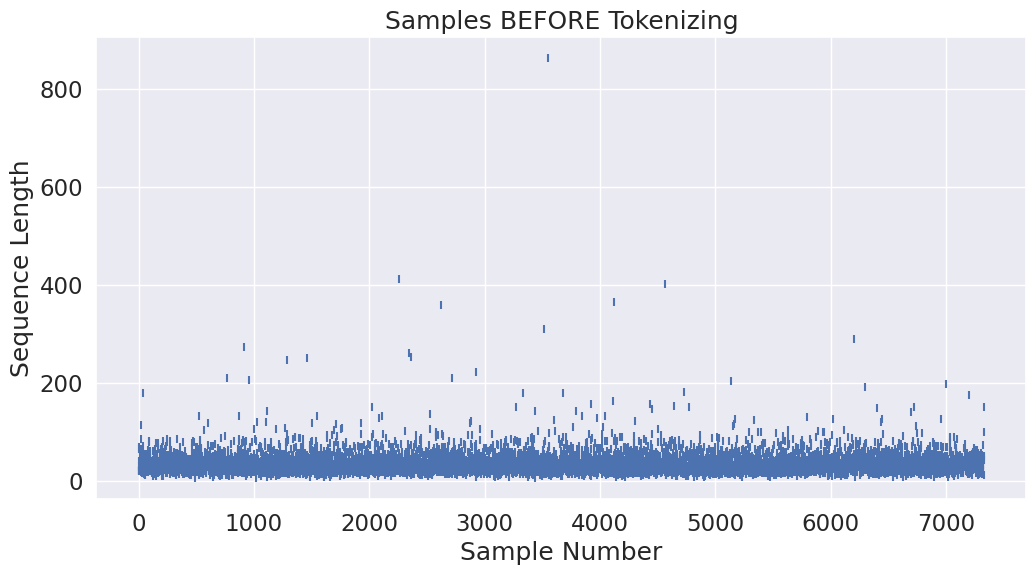

In [ ]:

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.scatter(range(0, len(lengths)), lengths, marker="|")

plt.xlabel('Sample Number')
plt.ylabel('Sequence Length')
plt.title('Samples BEFORE Tokenizing')

plt.show()

### Tokenizing the sequences

In [ ]:
max_input_length = 300

In [ ]:
full_input_ids = []
labels = []

# Tokenize all training examples
print('Tokenizing {:,} training samples...'.format(len(train_sentences)))

# Choose an interval on which to print progress updates.
update_interval = good_update_interval(total_iters=len(train_sentences), num_desired_updates=10)

# For each training example...
for text in train_sentences:

    # Report progress.
    if ((len(full_input_ids) % update_interval) == 0):
        print('  Tokenized {:,} samples.'.format(len(full_input_ids)))

    # Tokenize the sentence.
    input_ids = tokenizer.encode(text=text,
                                 add_special_tokens=True,
                                 max_length=max_input_length,
                                 truncation=True,
                                 padding=False)

    # Add the tokenized result to our list.
    full_input_ids.append(input_ids)

print('DONE.')
print('{:>10,} samples'.format(len(full_input_ids)))

Tokenizing 7,333 training samples...
  Tokenized 0 samples.
  Tokenized 700 samples.
  Tokenized 1,400 samples.
  Tokenized 2,100 samples.
  Tokenized 2,800 samples.
  Tokenized 3,500 samples.
  Tokenized 4,200 samples.
  Tokenized 4,900 samples.
  Tokenized 5,600 samples.
  Tokenized 6,300 samples.
  Tokenized 7,000 samples.
DONE.
     7,333 samples


In [ ]:
# Get all of the lengths.
unsorted_lengths = [len(x) for x in full_input_ids]

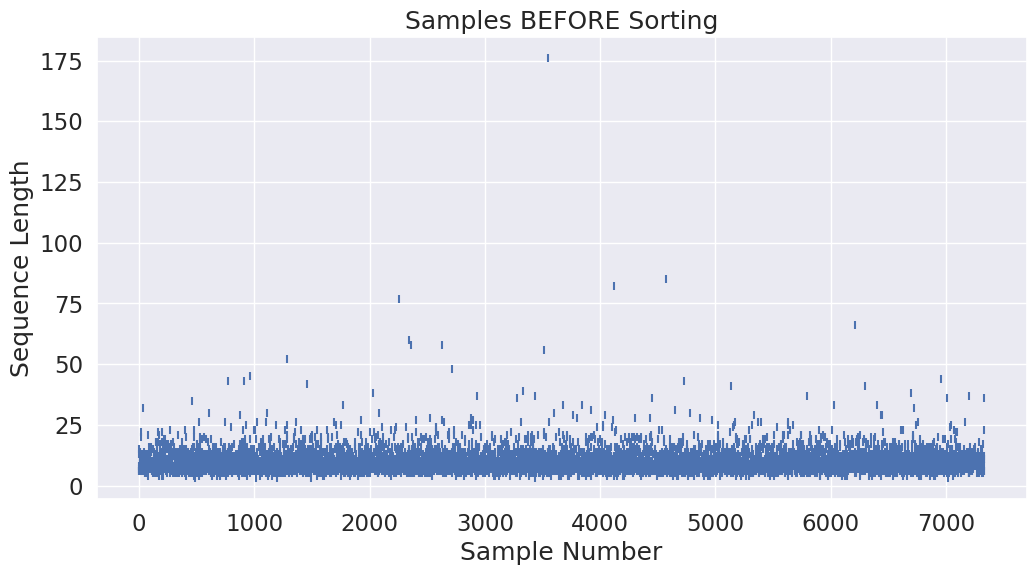

In [ ]:

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.scatter(range(0, len(unsorted_lengths)), unsorted_lengths, marker="|")

plt.xlabel('Sample Number')
plt.ylabel('Sequence Length')
plt.title('Samples BEFORE Sorting')

plt.show()

In [ ]:
# Sort the two lists together by the length of the input sequence.
train_samples = sorted(zip(full_input_ids, train_labels), key=lambda x: len(x[0]))

In [ ]:
train_samples[0:5]

[([101, 100, 102], 0),
 ([101, 12336, 102], 0),
 ([101, 18168, 102], 1),
 ([101, 13999, 102], 5),
 ([101, 46214, 102], 0)]

In [ ]:
print('Shortest sample:', len(train_samples[0][0]))
print('Longest sample:', len(train_samples[-1][0]))

Shortest sample: 3
Longest sample: 176


In [ ]:
# Get the new list of lengths after sorting.
sorted_lengths = [len(s[0]) for s in train_samples]

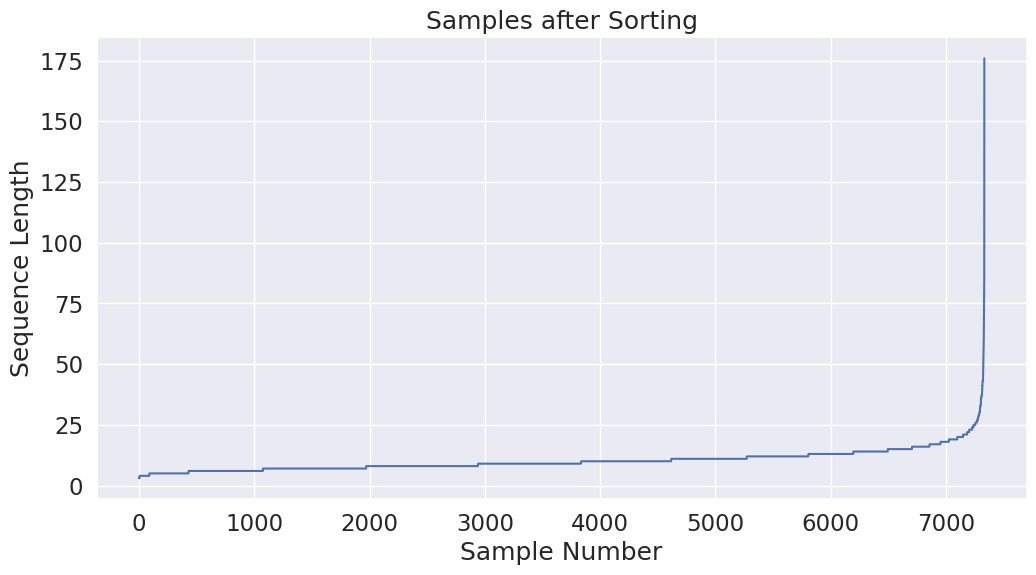

In [ ]:


plt.plot(range(0, len(sorted_lengths)), sorted_lengths)

plt.xlabel('Sample Number')
plt.ylabel('Sequence Length')
plt.title('Samples after Sorting')

plt.show()

### Random Batch Selections

In [ ]:
train_samples[0]

([101, 100, 102], 0)

In [ ]:
batch_size = 16

In [ ]:
# List of batches that we'll construct.
batch_ordered_sentences = []
batch_ordered_labels = []

print('Creating training batches of size {:}'.format(batch_size))

# Loop over all of the input samples...
while len(train_samples) > 0:

    # Report progress.
    if ((len(batch_ordered_sentences) % 100) == 0):
        print('  Selected {:,} batches.'.format(len(batch_ordered_sentences)))

    # `to_take` is our actual batch size. It will be `batch_size` until
    # we get to the last batch, which may be smaller.
    to_take = min(batch_size, len(train_samples))

    # Pick a random index in the list of remaining samples to start
    # our batch at.
    select = random.randint(0, len(train_samples) - to_take)

    # Select a contiguous batch of samples starting at `select`.
    batch = train_samples[select:(select + to_take)]

    # Each sample is a tuple--split them apart to create a separate list of
    # sequences and a list of labels for this batch.
    batch_ordered_sentences.append([s[0] for s in batch])
    batch_ordered_labels.append([s[1] for s in batch])

    # Remove these samples from the list.
    del train_samples[select:select + to_take]

print('\n  DONE - {:,} batches.'.format(len(batch_ordered_sentences)))

Creating training batches of size 16
  Selected 0 batches.
  Selected 100 batches.
  Selected 200 batches.
  Selected 300 batches.
  Selected 400 batches.

  DONE - 459 batches.


In [ ]:
print(batch_ordered_sentences[0])

[[101, 3405, 2137, 4621, 1019, 48813, 14625, 3230, 12309, 1014, 102], [101, 2131, 2209, 2123, 100, 2502, 5971, 13968, 2600, 2039, 102], [101, 4964, 2328, 14412, 42767, 2179, 16612, 46321, 7918, 999, 102], [101, 27023, 5903, 2866, 2370, 2106, 2083, 2559, 2086, 2115, 102], [101, 100, 7266, 13401, 4229, 2072, 2092, 2065, 2101, 2057, 102], [101, 12451, 2490, 2338, 2211, 3052, 2392, 100, 100, 100, 102], [101, 2286, 9586, 2541, 3714, 2039, 8434, 2113, 2077, 2044, 102], [101, 11968, 4465, 2130, 2078, 4027, 2261, 2083, 2044, 1014, 102], [101, 11968, 4465, 2130, 2078, 4027, 2261, 2083, 2044, 1014, 102], [101, 15698, 15123, 2274, 5008, 2304, 2218, 3248, 2114, 2039, 102], [101, 2209, 2237, 10066, 3445, 2128, 1011, 2259, 24511, 1014, 102], [101, 4639, 5439, 2052, 2145, 2073, 5589, 2040, 5934, 6456, 102], [101, 100, 1013, 11968, 4465, 2130, 5462, 4294, 2183, 1014, 102], [101, 2209, 2237, 10066, 3445, 2128, 1011, 2132, 24511, 1014, 102], [101, 18585, 14019, 26631, 26631, 11224, 11978, 5843, 3304, 63

In [ ]:
batch_ordered_labels[0]

[4, 4, 0, 5, 2, 5, 4, 1, 1, 4, 4, 0, 1, 4, 0, 3]

### Padding

In [ ]:
py_inputs = []
py_attn_masks = []
py_labels = []

# For each batch...
for (batch_inputs, batch_labels) in zip(batch_ordered_sentences, batch_ordered_labels):

    # New version of the batch, this time with padded sequences and now with
    # attention masks defined.
    batch_padded_inputs = []
    batch_attn_masks = []

    # First, find the longest sample in the batch.
    # Note that the sequences do currently include the special tokens!
    max_size = max([len(sen) for sen in batch_inputs])

    #print('Max size:', max_size)

    # For each input in this batch...
    for sen in batch_inputs:

        # How many pad tokens do we need to add?
        num_pads = max_size - len(sen)

        # Add `num_pads` padding tokens to the end of the sequence.
        padded_input = sen + [tokenizer.pad_token_id]*num_pads

        # Define the attention mask--it's just a `1` for every real token
        # and a `0` for every padding token.
        attn_mask = [1] * len(sen) + [0] * num_pads

        # Add the padded results to the batch.
        batch_padded_inputs.append(padded_input)
        batch_attn_masks.append(attn_mask)

    # Our batch has been padded, so we need to save this updated batch.
    # We also need the inputs to be PyTorch tensors, so we'll do that here.
    py_inputs.append(torch.tensor(batch_padded_inputs))
    py_attn_masks.append(torch.tensor(batch_attn_masks))
    py_labels.append(torch.tensor(batch_labels))


### Check the number of token reductions because of smart batching

In [ ]:
# Get the new list of lengths after sorting.

padded_lengths = []

# For each batch...
for batch in py_inputs:

    # For each sample...
    for s in batch:

        # Record its length.
        padded_lengths.append(len(s))

# Sum up the lengths to the get the total number of tokens after smart batching.
smart_token_count = np.sum(padded_lengths)

# To get the total number of tokens in the dataset using fixed padding, it's
# as simple as the number of samples times our `max_len` parameter (that we
# would pad everything to).
fixed_token_count = len(train_sentences) * max_input_length

# Calculate the percentage reduction.
prcnt_reduced = (fixed_token_count - smart_token_count) / float(fixed_token_count)

print('Total tokens:')
print('   Fixed Padding: {:,}'.format(fixed_token_count))
print('  Smart Batching: {:,}  ({:.1%} less)'.format(smart_token_count, prcnt_reduced))


Total tokens:
   Fixed Padding: 2,199,900
  Smart Batching: 78,305  (96.4% less)


## Load the model configuration from the transformers library using AutoConfig

In [ ]:
# Load the Config object, with an output configured for classification.
config = AutoConfig.from_pretrained(pretrained_model_name_or_path=model_name,
                                    num_labels=6)

print('Config type:', str(type(config)), '\n')


Config type: <class 'transformers.models.bert.configuration_bert.BertConfig'> 



In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name,config = config)

model.safetensors:   0%|          | 0.00/660M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sagorsarker/bangla-bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(102025, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

## Load the model from the transformers library using AutoModel

In [ ]:
# Load the pre-trained model for classification, passing in the `config` from
# above.
bert = AutoModel.from_pretrained(
    pretrained_model_name_or_path=model_name,
    config=config)

print('\nModel type:', str(type(bert)))



Model type: <class 'transformers.models.bert.modeling_bert.BertModel'>


In [ ]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

## Creating a custom BERT model

In [ ]:

# class BERT_Model(nn.Module):
#     ## defining the constructor for the class
#     def __init__(self, bert,num_labels):
#       ## calling the super class constructor
#       super(BERT_Model, self).__init__()
#       ## adding the bert layer to the model
#       self.bert = bert
#       # relu activation function
#       self.relu =  nn.ReLU()
#       # adding a dense layer to our custom model
#       self.fc1 = nn.Linear(768,512)
#       # adding another dense layer to our custom model ,i.e., the Output layer
#       self.fc2 = nn.Linear(512,num_labels)
#       # adding a softmax  activation function for our custom model's output layer
#       self.softmax = nn.LogSoftmax(dim=1)

#     #defining the forward pass
#     def forward(self, input_id, mask):
#       #pass the inputs to the model
#       outputs = self.bert(input_id,mask)

#       last_hidden_state = outputs.last_hidden_state       ## last hidden state from the model
#       pooler_output = outputs.pooler_output               ## pooler output from the model
#       ## adding a fully connected layer to the BERT model
#       x = self.fc1(pooler_output)
#       ## applying relu activation function
#       x = self.relu(x)
#       # the final output layer
#       x = self.fc2(x)
#       # apply softmax activation to our output layer
#       x = self.softmax(x)

#       return x

In [ ]:


# print('\nLoading model ...')
# # pass the pre-trained BERT to our define architecture
# model = BERT_Model(bert,num_labels=3)

# model.cuda()

## Custom Loss function

In [ ]:
# # convert class weights to tensor
# weights= torch.tensor(class_wts,dtype=torch.float)
# weights = weights.to(device)

# # loss function
# cross_entropy  = nn.NLLLoss(weight=weights)


## Loading Optimizer

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # This is the value Michael used.
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Loading lr scheduler

In [ ]:
# Number of training epochs. I chose to train for 1 simply because the training
# time is long. More epochs may improve the model's accuracy.
epochs = 5

# Total number of training steps is [number of batches] x [number of epochs].
# Note that it's the number of *batches*, not *samples*!
total_steps = len(py_inputs) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
# import numpy as np
# from sklearn.preprocessing import LabelEncoder

# # Check if all validation labels are present in the training labels
# missing_labels = set(val_labels) - set(train_labels)

# if missing_labels:
#     print(f"Warning: The following labels in validation data were not seen in the training data: {missing_labels}")
#     # Optionally, you could handle missing labels here, either by filtering or adding them to the encoder.
# else:
#     # Convert validation labels using the same LabelEncoder to ensure the mapping is consistent
#     val_labels_encoded = label_encoder.transform(val_labels)

# # Now continue with the rest of the training as planned.


## Training Loop

In [ ]:
import time
import torch
from sklearn.preprocessing import LabelEncoder

# Assuming your labels are strings like 'ham' and 'spam', we first fit the LabelEncoder on the training labels
label_encoder = LabelEncoder()

# Convert training labels to numeric values
train_labels_encoded = label_encoder.fit_transform(train_labels)

# Convert validation labels using the same LabelEncoder to ensure the mapping is consistent
val_labels_encoded = label_encoder.transform(val_labels)

# Now, we can proceed with the rest of the code for training and validation.

# We'll store a number of quantities such as training and validation loss, validation accuracy, and timings.
training_stats = {
    'epoch': [],
    'train_loss': [],
    'Training Time': [],
    'val_loss': [],
    'Validation Time': [],
    'train_acc': [],
    'val_acc': []
}

# Update every `update_interval` batches.
update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    predictions = []
    true_labels = []

    print("")
    print(f'======== Epoch {epoch_i + 1} / {epochs} ========')

    if epoch_i > 0:
        # Re-shuffle the dataset into new batches
        (py_inputs, py_attn_masks, py_labels) = make_smart_batches(train_sentences, train_labels_encoded, batch_size, tokenizer, max_input_length)

    print(f'Training on {len(py_inputs):,} batches...')

    t0 = time.time()
    total_train_loss = 0

    model.train()

    for step in range(0, len(py_inputs)):

        if step % update_interval == 0 and step != 0:
            elapsed = format_time(time.time() - t0)
            remaining_sec = (time.time() - t0) / step * (len(py_inputs) - step)
            remaining = format_time(remaining_sec)
            print(f'  Batch {step:>7,} of {len(py_inputs):>7,}. Elapsed: {elapsed}. Remaining: {remaining}')

        b_input_ids = py_inputs[step].to(device)
        b_input_mask = py_attn_masks[step].to(device)
        b_labels = py_labels[step].to(device)

        model.zero_grad()
        output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = output.loss
        logits = output.logits

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        predictions.append(logits)
        true_labels.append(label_ids)

        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(py_inputs)
    training_accuracy = check_accuracy(predictions, true_labels)
    training_time = format_time(time.time() - t0)

    print(f"  Average training loss: {avg_train_loss:.2f}")
    print(f"  Training Accuracy: {training_accuracy:.2f}")
    print(f"  Training epoch took: {training_time}")

    # Validation
    (py_inputs, py_attn_masks, py_labels) = make_smart_batches(val_sentences, val_labels_encoded, batch_size, tokenizer, max_input_length)
    val_loss, val_accuracy, validation_time = eval_model(model, py_inputs, py_attn_masks, py_labels)

    print("")
    print(f"  Average validation loss: {val_loss:.2f}")
    print(f"  Validation Accuracy: {val_accuracy:.2f}")
    print(f"  Validation epoch took: {validation_time}")

    # Record all statistics from this epoch.
    training_stats['epoch'].append(epoch_i + 1)
    training_stats['train_loss'].append(avg_train_loss)
    training_stats['Training Time'].append(training_time)
    training_stats['val_loss'].append(val_loss)
    training_stats['Validation Time'].append(validation_time)
    training_stats['train_acc'].append(training_accuracy)
    training_stats['val_acc'].append(val_accuracy)

print("")
print(f"Training complete! Total training took {format_time(time.time() - total_t0)} (h:mm:ss)")



======== Epoch 1 / 5 ========
Training on 459 batches...
  Batch      50 of     459. Elapsed: 0:00:06. Remaining: 0:00:46
  Batch     100 of     459. Elapsed: 0:00:10. Remaining: 0:00:36
  Batch     150 of     459. Elapsed: 0:00:15. Remaining: 0:00:30
  Batch     200 of     459. Elapsed: 0:00:19. Remaining: 0:00:25
  Batch     250 of     459. Elapsed: 0:00:24. Remaining: 0:00:20
  Batch     300 of     459. Elapsed: 0:00:28. Remaining: 0:00:15
  Batch     350 of     459. Elapsed: 0:00:32. Remaining: 0:00:10
  Batch     400 of     459. Elapsed: 0:00:37. Remaining: 0:00:05
  Batch     450 of     459. Elapsed: 0:00:41. Remaining: 0:00:01
  Average training loss: 1.15
  Training Accuracy: 0.56
  Training epoch took: 0:00:43
Creating Smart Batches from 917 examples with batch size 16...

Tokenizing 917 samples...
  Tokenized 0 samples.
  Tokenized 90 samples.
  Tokenized 180 samples.
  Tokenized 270 samples.
  Tokenized 360 samples.
  Tokenized 450 samples.
  Tokenized 540 samples.
  Tokeni

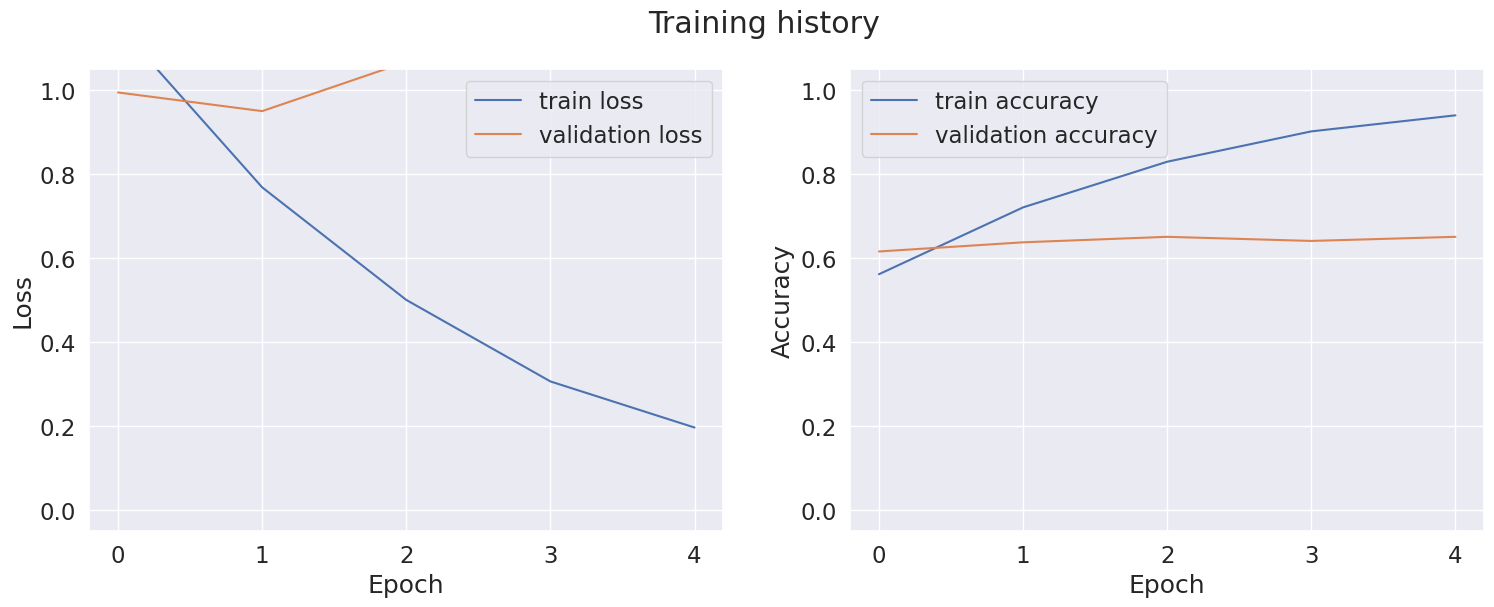

In [ ]:
plot_training_history(training_stats)

## Evaluating Performance Over Training Set

In [ ]:
(py_inputs, py_attn_masks, py_labels) = make_smart_batches(train_sentences, train_labels, batch_size ,tokenizer,max_input_length)

y_pred , y_true = get_predictions(py_inputs, py_attn_masks, py_labels)


Creating Smart Batches from 7,333 examples with batch size 16...

Tokenizing 7,333 samples...
  Tokenized 0 samples.
  Tokenized 700 samples.
  Tokenized 1,400 samples.
  Tokenized 2,100 samples.
  Tokenized 2,800 samples.
  Tokenized 3,500 samples.
  Tokenized 4,200 samples.
  Tokenized 4,900 samples.
  Tokenized 5,600 samples.
  Tokenized 6,300 samples.
  Tokenized 7,000 samples.
DONE.
     7,333 samples

     7,333 samples after sorting

Creating batches of size 16...

  DONE - Selected 459 batches.

Padding out sequences within each batch...
  DONE.
Predicting labels for 459 test batches...
  Batch      50  of      459.    Elapsed: 0:00:01.  Remaining: 0:00:09
  Batch     100  of      459.    Elapsed: 0:00:02.  Remaining: 0:00:08
  Batch     150  of      459.    Elapsed: 0:00:03.  Remaining: 0:00:07
  Batch     200  of      459.    Elapsed: 0:00:04.  Remaining: 0:00:05
  Batch     250  of      459.    Elapsed: 0:00:05.  Remaining: 0:00:04
  Batch     300  of      459.    Elapsed: 0

In [ ]:
print(classification_report(y_true, y_pred, target_names=class_names))

                       precision    recall  f1-score   support

        Cyberbullying       0.96      0.98      0.97      1984
     Religious_Hatred       0.97      0.95      0.96       802
Gender_Discrimination       0.99      0.98      0.98       984
              Sarcasm       0.97      0.95      0.96       815
            Political       0.98      0.97      0.97       891
               Racism       0.97      0.98      0.98      1857

             accuracy                           0.97      7333
            macro avg       0.97      0.97      0.97      7333
         weighted avg       0.97      0.97      0.97      7333



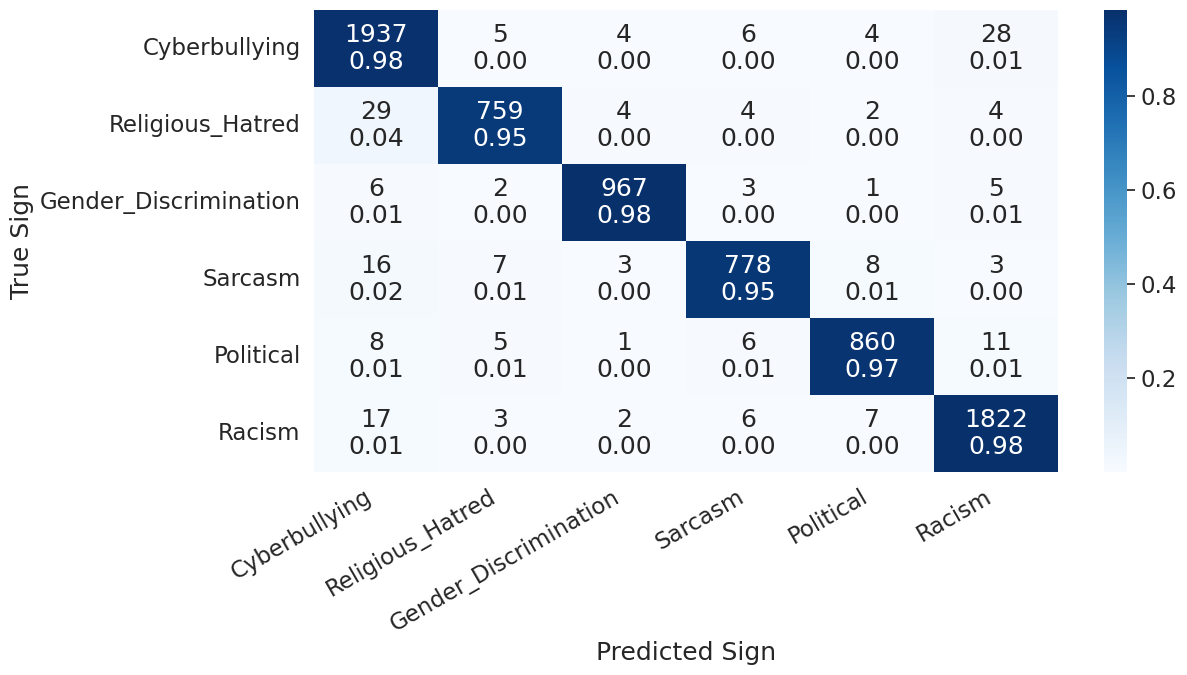

In [ ]:
cm = confusion_matrix(y_true, y_pred)
show_confusion_matrix(cm, class_names)

## Evaluating Performance Over Validation Set

In [ ]:
(py_inputs, py_attn_masks, py_labels) = make_smart_batches(val_sentences, val_labels, batch_size ,tokenizer,max_input_length)

y_pred , y_true = get_predictions(py_inputs, py_attn_masks, py_labels)

Creating Smart Batches from 917 examples with batch size 16...

Tokenizing 917 samples...
  Tokenized 0 samples.
  Tokenized 90 samples.
  Tokenized 180 samples.
  Tokenized 270 samples.
  Tokenized 360 samples.
  Tokenized 450 samples.
  Tokenized 540 samples.
  Tokenized 630 samples.
  Tokenized 720 samples.
  Tokenized 810 samples.
  Tokenized 900 samples.
DONE.
       917 samples

       917 samples after sorting

Creating batches of size 16...

  DONE - Selected 58 batches.

Padding out sequences within each batch...
  DONE.
Predicting labels for 58 test batches...
  Batch       6  of       58.    Elapsed: 0:00:00.  Remaining: 0:00:01
  Batch      12  of       58.    Elapsed: 0:00:00.  Remaining: 0:00:01
  Batch      18  of       58.    Elapsed: 0:00:00.  Remaining: 0:00:01
  Batch      24  of       58.    Elapsed: 0:00:00.  Remaining: 0:00:01
  Batch      30  of       58.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch      36  of       58.    Elapsed: 0:00:01.  Remaining: 0:00:

In [ ]:
print(classification_report(y_true, y_pred, target_names=class_names))

                       precision    recall  f1-score   support

        Cyberbullying       0.62      0.61      0.62       271
     Religious_Hatred       0.66      0.63      0.65        95
Gender_Discrimination       0.77      0.74      0.75       134
              Sarcasm       0.58      0.58      0.58        92
            Political       0.77      0.80      0.79       107
               Racism       0.58      0.61      0.60       218

             accuracy                           0.65       917
            macro avg       0.66      0.66      0.66       917
         weighted avg       0.65      0.65      0.65       917



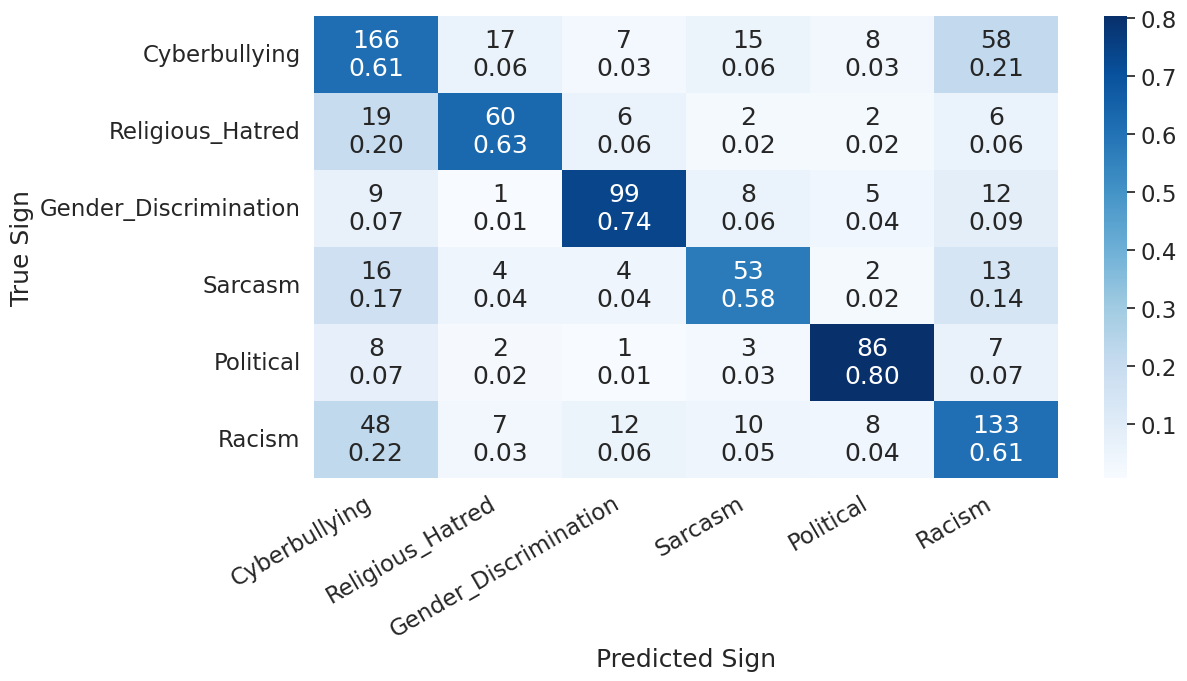

In [ ]:
cm = confusion_matrix(y_true, y_pred)
show_confusion_matrix(cm, class_names)

## Making Predictions on Test Set

In [ ]:
test_df

,PID,text,labels
6860,6779,"বর্ণবাদী মন্তব্য মানুষকে বিভক্ত করে, আর পৃথিবী...",Racism
2245,2246,লাজ লজ্জা হিন কিছু ফোটফটে সুন্দর,Cyberbullying
7133,7052,খুন লুটপাট ডাকাতি অগ্নিসংযোগ শিক্ষক লাঞ্চিত কর...,Gender_Discrimination
4410,4337,এরা হলো ইসলামের বড় শত্রু,Religious_Hatred
7487,7406,ছেলেরা মেয়েদের মতো কোনো গুরুত্বপূর্ণ কাজ করতে...,Gender_Discrimination
...,...,...,...
9209,9127,বেশ্যা পেট থেকে জন্ম নিছিস মাগী তোর মায়েরে চুদী,Gender_Discrimination
2994,2961,ও দিবো পান্তার হোটেল,Sarcasm
1402,1403,শোবে তাই গরুর ঘরে শুয়ে থাকে,Cyberbullying
6604,6523,শেখ হাসিনা ছাড়া এ দেশ কারোর কাছে নিরাপদ নয়,Political


## Loading `test_sentences`

In [ ]:
test_sentences = test_df['text'].values
test_labels = test_df['labels'].values
test_ids = test_df.index.values

In [ ]:
test_ids

array([6860, 2245, 7133, 4410, 7487, 7841, 6597, 7875,  354, 4215, 8152,
       8257, 1452, 5535, 5412, 8634,  108, 1147, 6439, 7230, 8801, 5239,
       7607, 6334, 3125, 6709, 5746, 1414, 8227, 2036, 4264, 6089, 3060,
       4865, 7071,  852, 8709, 7934, 1527, 1103, 3483, 6755, 7093, 4130,
       5957,  693, 1790, 2543, 3233, 2465, 2579, 2310, 3400, 2455, 8352,
       8095, 6400, 5893, 2683, 1446, 8430, 1115, 9069, 6464, 3136, 5504,
       6562, 9190, 7495, 5830, 1020, 6362, 3689, 6042, 5472, 2436, 8817,
       6627, 4345, 8362, 6489, 2759, 7540, 4890, 8191, 2548, 5478, 7543,
       2138, 8907, 6230, 5686, 7747, 1061, 1052, 4150, 5729, 7901, 1550,
       9098, 3422, 5324, 3943, 4368, 6044, 6350, 3761, 6001, 1071,  334,
       2868, 3532,  733, 4319, 7583, 4387, 4615,   14, 7705, 8517, 9092,
       7419, 1470, 2825, 3362, 5185, 3846, 6459, 3031, 9122, 1945, 3520,
        286, 2897, 2523, 4023, 1346, 7992,  473, 2362, 5024, 6856,  447,
        927, 4992, 2189, 6983, 3699, 3935, 6161, 55

In [ ]:
(py_inputs, py_attn_masks,py_ids) = make_smart_batches_on_test(test_sentences,test_ids, 16,tokenizer,max_input_length)

Creating Smart Batches from 917 examples with batch size 16...

Tokenizing 917 samples...
  Tokenized 0 samples.
  Tokenized 90 samples.
  Tokenized 180 samples.
  Tokenized 270 samples.
  Tokenized 360 samples.
  Tokenized 450 samples.
  Tokenized 540 samples.
  Tokenized 630 samples.
  Tokenized 720 samples.
  Tokenized 810 samples.
  Tokenized 900 samples.
DONE.
       917 samples

       917 samples after sorting

Creating batches of size 16...

  DONE - Selected 58 batches.

Padding out sequences within each batch...
  DONE.


In [ ]:
y_ids,y_preds  = get_predictions_test(py_inputs, py_attn_masks,py_ids)


Predicting labels for 58 test batches...
  Batch       6  of       58.    Elapsed: 0:00:00.  Remaining: 0:00:01
  Batch      12  of       58.    Elapsed: 0:00:00.  Remaining: 0:00:01
  Batch      18  of       58.    Elapsed: 0:00:00.  Remaining: 0:00:01
  Batch      24  of       58.    Elapsed: 0:00:00.  Remaining: 0:00:01
  Batch      30  of       58.    Elapsed: 0:00:00.  Remaining: 0:00:00
  Batch      36  of       58.    Elapsed: 0:00:01.  Remaining: 0:00:00
  Batch      42  of       58.    Elapsed: 0:00:01.  Remaining: 0:00:00
  Batch      48  of       58.    Elapsed: 0:00:01.  Remaining: 0:00:00
  Batch      54  of       58.    Elapsed: 0:00:01.  Remaining: 0:00:00


In [ ]:
test_sentences

array(['বর্ণবাদী মন্তব্য মানুষকে বিভক্ত করে, আর পৃথিবী এমনিতেই ভাঙা কাঁচের মতো ভেঙে যাচ্ছে!',
       'লাজ লজ্জা হিন কিছু ফোটফটে সুন্দর',
       'খুন লুটপাট ডাকাতি অগ্নিসংযোগ শিক্ষক লাঞ্চিত করা মোরুব্বিদের অপমান করা।',
       'এরা হলো ইসলামের বড় শত্রু',
       'ছেলেরা মেয়েদের মতো কোনো গুরুত্বপূর্ণ কাজ করতে পারে না।',
       'তুই কালো জাতির অংশ।',
       'শেখ হাসিনার SSF এই জঙ্গির\u200c জন্য নিয়োগ দেওয়া হোক',
       'জাতি হিসেবে সম্পূর্ণ অযোগ্য।',
       'পৃথিবীতে তোর মতন নির্লজ্জ আমি আর কাউকেই দেখিনি',
       'দেশ জয় এর পর পচা ময়লা বাংলাদেশ থেকে দূরে ভারতের ডাস্টবিন এ ফালানো হবে',
       '১২ ভাতারি কে গুছিয়ে কেলা',
       'কত জন যে চুদছে মাগীর ভোদাতে  স্পর্শীয়া মাগী',
       'ভাই তর পায়ে পড়ি গোল দিছ না', 'নাহিদ সাহেব সুস্থ আছে তো?',
       'মর এবার জল খাইয়া',
       'ঐ মালাউনের বাচ্চাকে খালী মাঠে ছেড়ে দেওয়া হউক তার বিচার জনগণ করবে',
       'আবাল কে দিয়েছে অধিনায়কের দায়িত্ব।', 'লুইচ্চার কাছে সকলে যায়।',
       'এটাই তাট যোগ্য স্থান', 'আগামী ভবিষ্যতে নিয়ে সত্যিই চিন্তিত।',
       'বাল

In [ ]:
(py_inputs, py_attn_masks,py_ids) = make_smart_batches_on_test(test_sentences,test_ids, 16,tokenizer,max_input_length)
y_pred , y_true = get_predictions(py_inputs, py_attn_masks, py_labels)

Creating Smart Batches from 917 examples with batch size 16...

Tokenizing 917 samples...
  Tokenized 0 samples.
  Tokenized 90 samples.
  Tokenized 180 samples.
  Tokenized 270 samples.
  Tokenized 360 samples.
  Tokenized 450 samples.
  Tokenized 540 samples.
  Tokenized 630 samples.
  Tokenized 720 samples.
  Tokenized 810 samples.
  Tokenized 900 samples.
DONE.
       917 samples

       917 samples after sorting

Creating batches of size 16...

  DONE - Selected 58 batches.

Padding out sequences within each batch...
  DONE.
Predicting labels for 58 test batches...
  Batch       6  of       58.    Elapsed: 0:00:00.  Remaining: 0:00:01
  Batch      12  of       58.    Elapsed: 0:00:00.  Remaining: 0:00:01
  Batch      18  of       58.    Elapsed: 0:00:00.  Remaining: 0:00:01
  Batch      24  of       58.    Elapsed: 0:00:00.  Remaining: 0:00:01
  Batch      30  of       58.    Elapsed: 0:00:01.  Remaining: 0:00:01
  Batch      36  of       58.    Elapsed: 0:00:01.  Remaining: 0:00:

In [ ]:
y_pred

array([3, 5, 1, 4, 4, 0, 0, 2, 0, 0, 1, 5, 0, 0, 0, 0, 0, 5, 4, 5, 1, 3,
       2, 1, 4, 2, 3, 0, 2, 0, 0, 4, 4, 4, 5, 2, 5, 4, 5, 0, 5, 1, 5, 0,
       0, 1, 5, 5, 0, 0, 5, 4, 3, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 5, 2, 4,
       2, 2, 0, 0, 4, 4, 0, 1, 1, 3, 0, 2, 5, 0, 0, 1, 4, 2, 0, 0, 3, 1,
       3, 5, 2, 1, 2, 4, 0, 4, 1, 1, 3, 5, 4, 0, 5, 0, 0, 2, 2, 2, 4, 4,
       0, 0, 3, 1, 0, 5, 0, 2, 5, 3, 3, 3, 5, 0, 5, 4, 4, 5, 2, 5, 0, 0,
       0, 5, 0, 5, 0, 0, 3, 5, 0, 3, 5, 0, 5, 3, 4, 5, 5, 2, 4, 5, 3, 4,
       4, 3, 0, 0, 1, 3, 1, 3, 0, 5, 0, 0, 2, 2, 2, 4, 0, 4, 2, 2, 0, 2,
       0, 0, 5, 4, 0, 4, 5, 5, 5, 0, 0, 0, 0, 1, 3, 2, 0, 1, 0, 0, 3, 5,
       0, 5, 2, 4, 2, 2, 5, 0, 0, 4, 4, 3, 2, 5, 2, 0, 3, 2, 2, 5, 2, 0,
       2, 4, 2, 0, 5, 0, 1, 4, 0, 1, 4, 1, 2, 3, 5, 5, 0, 1, 1, 2, 5, 2,
       2, 2, 5, 5, 3, 2, 3, 1, 0, 0, 4, 0, 3, 2, 5, 0, 4, 0, 0, 5, 4, 3,
       1, 5, 1, 0, 4, 1, 5, 0, 0, 0, 5, 4, 5, 5, 0, 2, 2, 0, 0, 5, 5, 0,
       3, 0, 5, 5, 0, 0, 0, 3, 1, 2, 2, 0, 5, 4, 0,

## Evaluating accuracy over test set

In [ ]:
y_ids,y_preds  = get_predictions_test(py_inputs, py_attn_masks,py_ids)


Predicting labels for 58 test batches...
  Batch       6  of       58.    Elapsed: 0:00:00.  Remaining: 0:00:01
  Batch      12  of       58.    Elapsed: 0:00:00.  Remaining: 0:00:01
  Batch      18  of       58.    Elapsed: 0:00:00.  Remaining: 0:00:01
  Batch      24  of       58.    Elapsed: 0:00:01.  Remaining: 0:00:01
  Batch      30  of       58.    Elapsed: 0:00:01.  Remaining: 0:00:01
  Batch      36  of       58.    Elapsed: 0:00:01.  Remaining: 0:00:00
  Batch      42  of       58.    Elapsed: 0:00:01.  Remaining: 0:00:00
  Batch      48  of       58.    Elapsed: 0:00:01.  Remaining: 0:00:00
  Batch      54  of       58.    Elapsed: 0:00:01.  Remaining: 0:00:00


In [ ]:
print(y_preds)

[3 5 1 4 4 0 0 2 0 0 1 5 0 0 0 0 0 5 4 5 1 3 2 1 4 2 3 0 2 0 0 4 4 4 5 2 5
 4 5 0 5 1 5 0 0 1 5 5 0 0 5 4 3 0 0 0 0 0 5 0 0 0 0 5 2 4 2 2 0 0 4 4 0 1
 1 3 0 2 5 0 0 1 4 2 0 0 3 1 3 5 2 1 2 4 0 4 1 1 3 5 4 0 5 0 0 2 2 2 4 4 0
 0 3 1 0 5 0 2 5 3 3 3 5 0 5 4 4 5 2 5 0 0 0 5 0 5 0 0 3 5 0 3 5 0 5 3 4 5
 5 2 4 5 3 4 4 3 0 0 1 3 1 3 0 5 0 0 2 2 2 4 0 4 2 2 0 2 0 0 5 4 0 4 5 5 5
 0 0 0 0 1 3 2 0 1 0 0 3 5 0 5 2 4 2 2 5 0 0 4 4 3 2 5 2 0 3 2 2 5 2 0 2 4
 2 0 5 0 1 4 0 1 4 1 2 3 5 5 0 1 1 2 5 2 2 2 5 5 3 2 3 1 0 0 4 0 3 2 5 0 4
 0 0 5 4 3 1 5 1 0 4 1 5 0 0 0 5 4 5 5 0 2 2 0 0 5 5 0 3 0 5 5 0 0 0 3 1 2
 2 0 5 4 0 0 4 4 0 0 5 3 5 4 4 5 5 0 4 5 0 1 2 0 2 1 1 0 0 4 5 2 5 1 0 2 5
 1 1 1 5 4 5 4 5 0 4 5 4 0 2 5 0 0 5 2 2 5 5 5 5 3 4 0 5 5 5 5 3 5 0 4 1 0
 1 5 0 0 0 5 5 5 0 2 0 2 2 3 5 2 1 2 4 0 4 2 4 0 0 3 5 3 3 5 5 5 5 5 0 2 0
 5 1 0 0 4 5 5 0 2 1 1 4 0 5 5 1 5 4 0 5 3 5 0 2 5 0 4 1 0 3 4 0 0 4 5 3 0
 0 1 2 2 5 1 2 4 0 5 2 0 2 2 0 2 4 2 5 0 4 0 0 5 3 5 1 4 5 4 5 5 0 5 1 0 3
 4 5 4 0 5 2 1 2 0 4 4 5 

In [ ]:
print(y_ids)

[1937 1670 9144 6996 6982 4580 8430 3689 2189 3222 8364 8081 9180 1153
 9091  118 4696 1315 7009 1631 7428 6388 2697 7378 4988 3872  789 9241
 4009 2644 1018 5451 4368 1071 2868   14 2897 7702 1068 1501  304  868
 1373 3205 8703 3355 6810 4502 5911 8719 1721 1180 1438 2855 8134 3007
 2886 5735 6324 6735 3526 5825 6253 2029 6400 8362 3699 5924 3801 8411
 4129 5077 6498 8236 8257 8634  693 5893 6373  611 4888 6828   12 6480
 1078 8597 7900 7483 8514 2275 3587 7339 7217 7547 4147 4906 4021 7371
 6334   31 5023  107  763   96   65 5530 6613 2515 3404 4447 4908 9209
 1915 6158 5545 5392 2910  711 5535 7230 7071  852 1527 1115 3136 6562
 5472 2436 8225  149 2876 8406  474 7200 2088 1417 8660  318 1662 1297
 1626 1406 8488   76 8846  982 5107 1780 6238 6469 6210  429 5073 7939
 4468 7822 1156 4955 3202 7550 7093 6362 5219 7103 9045 4104 5900 4006
 6044 4893 5654 6827  180 5991 8276 8415 2867  683 3790 1224 1349 8999
 3211 1155 4754 3582 1369 1729 8076 7349 4704 1339 5544 6772 9107  957
 8762 

In [ ]:
le.inverse_transform(y_preds)

array(['Racism', 'Sarcasm', 'Gender_Discrimination', 'Religious_Hatred',
       'Religious_Hatred', 'Cyberbullying', 'Cyberbullying', 'Political',
       'Cyberbullying', 'Cyberbullying', 'Gender_Discrimination',
       'Sarcasm', 'Cyberbullying', 'Cyberbullying', 'Cyberbullying',
       'Cyberbullying', 'Cyberbullying', 'Sarcasm', 'Religious_Hatred',
       'Sarcasm', 'Gender_Discrimination', 'Racism', 'Political',
       'Gender_Discrimination', 'Religious_Hatred', 'Political', 'Racism',
       'Cyberbullying', 'Political', 'Cyberbullying', 'Cyberbullying',
       'Religious_Hatred', 'Religious_Hatred', 'Religious_Hatred',
       'Sarcasm', 'Political', 'Sarcasm', 'Religious_Hatred', 'Sarcasm',
       'Cyberbullying', 'Sarcasm', 'Gender_Discrimination', 'Sarcasm',
       'Cyberbullying', 'Cyberbullying', 'Gender_Discrimination',
       'Sarcasm', 'Sarcasm', 'Cyberbullying', 'Cyberbullying', 'Sarcasm',
       'Religious_Hatred', 'Racism', 'Cyberbullying', 'Cyberbullying',
       'Cybe

<Axes: xlabel='count'>

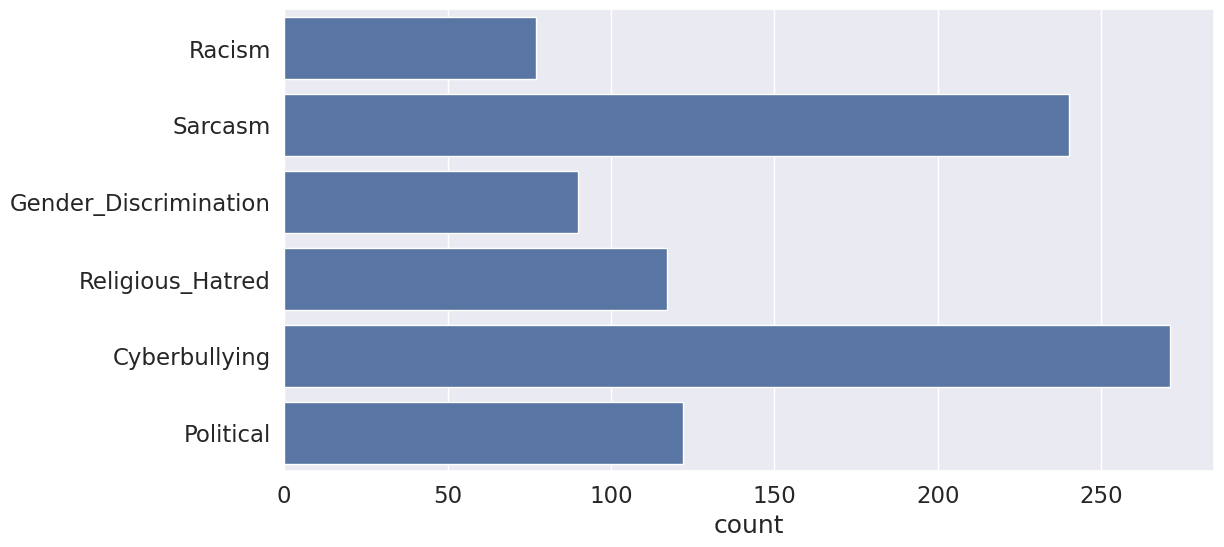

In [ ]:
sns.countplot(y =le.inverse_transform(y_preds))

In [ ]:
len(y_ids)

917

In [ ]:
y_pred=le.inverse_transform(y_preds)
y_pred

array(['Racism', 'Sarcasm', 'Gender_Discrimination', 'Religious_Hatred',
       'Religious_Hatred', 'Cyberbullying', 'Cyberbullying', 'Political',
       'Cyberbullying', 'Cyberbullying', 'Gender_Discrimination',
       'Sarcasm', 'Cyberbullying', 'Cyberbullying', 'Cyberbullying',
       'Cyberbullying', 'Cyberbullying', 'Sarcasm', 'Religious_Hatred',
       'Sarcasm', 'Gender_Discrimination', 'Racism', 'Political',
       'Gender_Discrimination', 'Religious_Hatred', 'Political', 'Racism',
       'Cyberbullying', 'Political', 'Cyberbullying', 'Cyberbullying',
       'Religious_Hatred', 'Religious_Hatred', 'Religious_Hatred',
       'Sarcasm', 'Political', 'Sarcasm', 'Religious_Hatred', 'Sarcasm',
       'Cyberbullying', 'Sarcasm', 'Gender_Discrimination', 'Sarcasm',
       'Cyberbullying', 'Cyberbullying', 'Gender_Discrimination',
       'Sarcasm', 'Sarcasm', 'Cyberbullying', 'Cyberbullying', 'Sarcasm',
       'Religious_Hatred', 'Racism', 'Cyberbullying', 'Cyberbullying',
       'Cybe

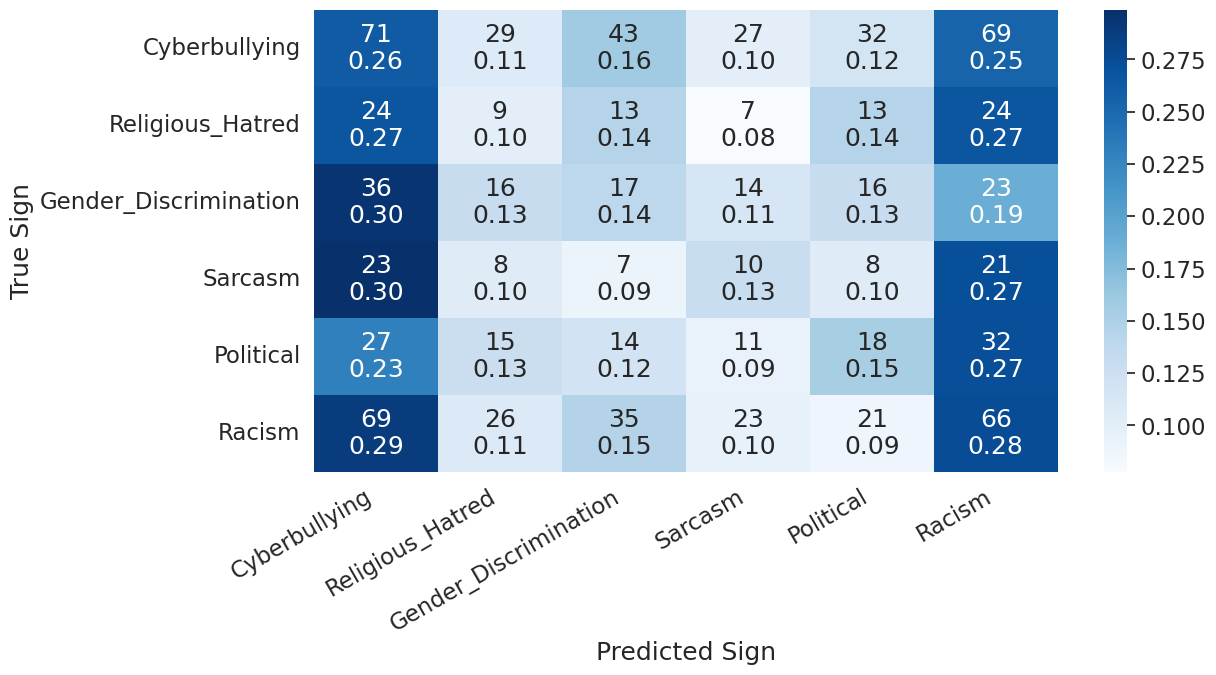

In [ ]:
cm = confusion_matrix(y_pred, test_labels)
show_confusion_matrix(cm, class_names)

Classification Report:
                       precision    recall  f1-score   support

        Cyberbullying     0.2620    0.2840    0.2726       250
     Religious_Hatred     0.1000    0.0874    0.0933       103
Gender_Discrimination     0.1393    0.1318    0.1355       129
              Sarcasm     0.1299    0.1087    0.1183        92
            Political     0.1538    0.1667    0.1600       108
               Racism     0.2750    0.2809    0.2779       235

             accuracy                         0.2083       917
            macro avg     0.1767    0.1766    0.1763       917
         weighted avg     0.2039    0.2083    0.2058       917



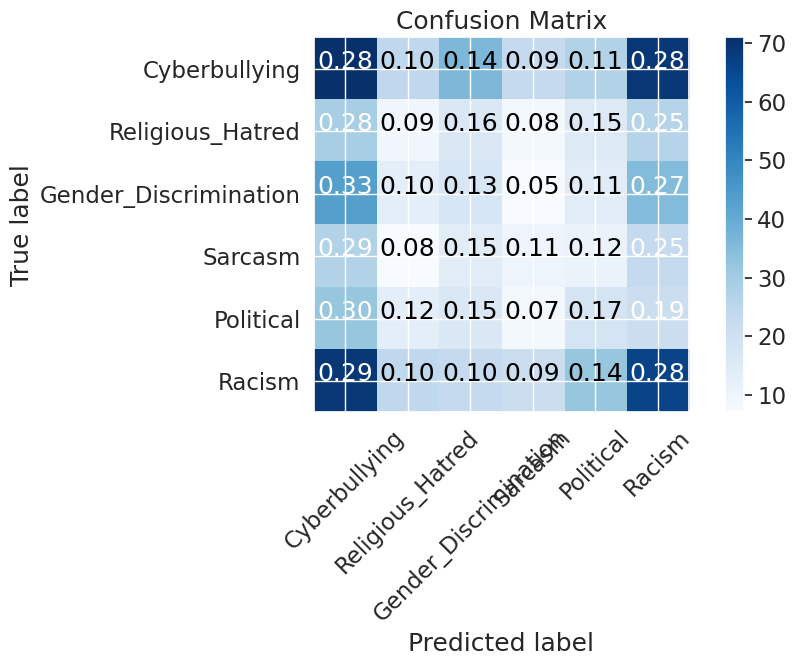

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Assuming y_pred and test_labels are defined
# Convert predictions to class labels if they are probabilities (if needed)
# y_pred_classes = np.argmax(y_pred, axis=1)

# Generate the classification report
print("Classification Report:")
print(classification_report(test_labels, y_pred, target_names=class_names, zero_division=0, digits=4))

# Create the confusion matrix
cm = confusion_matrix(test_labels, y_pred)

# Function to display the confusion matrix
def show_confusion_matrix(cm, classes):
    plt.figure(figsize=(10, 7))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Normalize the confusion matrix by row (i.e., by the number of samples in each class)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm_normalized.max() / 2.
    for i, j in np.ndindex(cm_normalized.shape):
        plt.text(j, i, format(cm_normalized[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm_normalized[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Display the confusion matrix
show_confusion_matrix(cm, class_names)
